In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody

from astroquery.sdss import SDSS

from specutils import Spectrum1D
import speclite.filters
from scipy.optimize import curve_fit, Bounds

pd.set_option('display.max_columns', None)

In [2]:
query = 'SELECT TOP 20 \
so.SpecObjId, so.ra, so.dec, so.subClass, \
so.modelMag_u, so.modelMag_g, so.modelMag_r, so.modelMag_i, so.modelMag_z, so.z AS redshift, \
sp.teffadop, sp.fehadop, sp.loggadop, sp.snr \
FROM SpecPhotoAll so \
JOIN sppParams sp ON so.specObjID = sp.specObjID and so.sciencePrimary=1 \
WHERE \
 so.class = "STAR" \
AND \
 so.zwarning = 0'
result = SDSS.query_sql(query, encoding=None, data_release=16)


/Users/jwatts/CelestialNav/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [3]:
df = result.to_pandas()
df['SpecObjId'] = df['SpecObjId'].astype(str)
df['subClass'] = df.subClass.apply(lambda x: x.decode('utf-8'))
df= df.dropna().reset_index(drop=True)
df.head(20)

,SpecObjId,ra,dec,subClass,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,redshift,teffadop,fehadop,loggadop,snr
0,299493525735630848,146.91375,-0.644481,A0,19.44140,18.08051,18.09170,18.14256,18.22256,0.000601,7968.877,-1.239587,4.101296,19.753190
1,299496549392607232,147.25534,-0.319337,WD,16.94885,16.49758,16.64236,16.81161,17.01174,-0.000244,8898.379,-3.334459,4.454614,38.597680
2,299497923782141952,147.01792,-0.127266,WD,18.67938,18.26975,18.34097,18.46216,18.59776,-0.000066,8550.988,-3.247782,4.261247,14.534160
3,299498198660048896,147.09176,-0.077346,WD,20.44799,20.04500,20.30676,20.50662,21.07875,-0.000259,-9999.000,-9999.000000,-9999.000000,3.897516
4,299499573049583616,147.32107,-0.006576,WD,19.25758,18.79353,18.93591,19.10642,19.30586,-0.000260,8855.012,-2.523250,4.220379,10.142580
5,299499847927490560,146.94386,0.039169,G2,18.29695,17.00027,16.44970,16.20717,16.10233,0.000161,5837.667,-0.795151,4.010286,40.846300
6,299505070607722496,146.47335,-0.584510,CV,20.90656,24.98726,24.91837,25.04552,23.23400,0.000152,-9999.000,-9999.000000,-9999.000000,7.905121
7,299506994753071104,146.83368,-0.335970,M6,22.26557,19.20024,17.52558,15.24870,14.05043,-0.000064,-9999.000,-9999.000000,-9999.000000,33.801080
8,299511942555396096,146.17616,-0.982441,A0,18.88086,17.73562,17.57361,17.55848,17.56570,0.000226,7110.624,-0.486169,4.213307,24.237300
9,299525136694929408,145.83254,-1.002709,F5,17.69156,16.58506,16.22235,16.07985,16.03837,0.000016,6088.316,-0.676387,4.081367,43.395330


In [4]:
# Select a Star
index = 16 #df['teffadop'].idxmax()
ra = df.loc[index, 'ra']
dec = df.loc[index, 'dec']
redshift = df.loc[index, 'redshift']
modelMag_u = df.loc[index, 'modelMag_u']
modelMag_g = df.loc[index, 'modelMag_g']
modelMag_r = df.loc[index, 'modelMag_r']
modelMag_i = df.loc[index, 'modelMag_i']
modelMag_z = df.loc[index, 'modelMag_z']
temp_eff = df.loc[index, 'teffadop'] * u.K

pos = SkyCoord(ra, dec, unit="deg", frame='icrs')
print("RA: {}".format(pos.ra))
print("dec: {}".format(pos.dec))
print("redshift: {}".format(redshift))
print("temp_eff: {}".format(temp_eff))

RA: 145.67423 deg
dec: -0.38081052 deg
redshift: -0.0001019948
temp_eff: 6023.736 K


In [5]:
# Obtain the spectrum
# Units:
# wavelength - log wavelength in AA
# flux - e-17 erg cm-2 s-1 Å-1
# source: https://www.sdss4.org/dr16/spectro/spectro_basics/

flux_units = u.erg/u.s/u.cm**2/u.AA

xid = SDSS.query_region(pos, spectro=True)

spectra = SDSS.get_spectra(matches=xid)
spectral_data = spectra[0][1].data

wavelength = 10**spectral_data['loglam'] * u.AA
flux = spectral_data['flux'] * pow(10,-17) * flux_units

In [6]:
# Find a Blackbody curve to approximate the spectrum.

# First define the planck function given temperature and wavelength
def planck_wavelength(wavelength, temperature, scale=1):
    wavelength = wavelength.to(u.m)
    numerator = 2*const.h*const.c**2/wavelength**5
    exponent = const.h*const.c/(wavelength*const.k_B*temperature)
    denominator = np.exp(exponent.value)-1
    
    return scale * (numerator/denominator).to(flux_units)

# Second define the curve fit function (adds units on input, removes on output)
def planck_wavelength_curvefit(wavelength, temperature, scale):
    wavelength *= u.AA
    temperature *= u.K
    return planck_wavelength(wavelength, temperature, scale).value

# Third define initial guess and bounds for temperature and scale
temp_guess = temp_eff.value if (temp_eff>0) else 5000
initial_guess = [temp_guess, 1e-17]  
bounds=((0, -np.inf), (np.inf, np.inf))

# Last perform the curve fit
# Fit the blackbody function to the observed data
params_opt, params_cov = curve_fit(planck_wavelength_curvefit, wavelength, flux, p0=initial_guess, bounds=bounds)

fitted_temperature, fitted_scale = params_opt
fitted_temperature *= u.K
print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)

flux_fitted = planck_wavelength(wavelength, fitted_temperature, fitted_scale)


# Alternate with Astropy BlackBody model - double check my planck_wavelength function results
def blackbody_function (wavelength, temp, scale):
    wavelength = wavelength * u.AA
    bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
    return bb(wavelength).value

params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)

bb_fitted_temperature, bb_fitted_scale = params_opt
bb_fitted_temperature *= u.K
print("Fitted Temperature:", bb_fitted_temperature)
print("Fitted Amplitude:", bb_fitted_scale)

bb = BlackBody(temperature=bb_fitted_temperature, scale=bb_fitted_scale*flux_units/u.sr)
bb_flux_fitted = bb(wavelength)

Fitted Temperature: 6029.607355783276 K
Fitted Amplitude: 3.7841084848309145e-22
Fitted Temperature: 6029.607355783276 K
Fitted Amplitude: 3.7841084848309183e-22


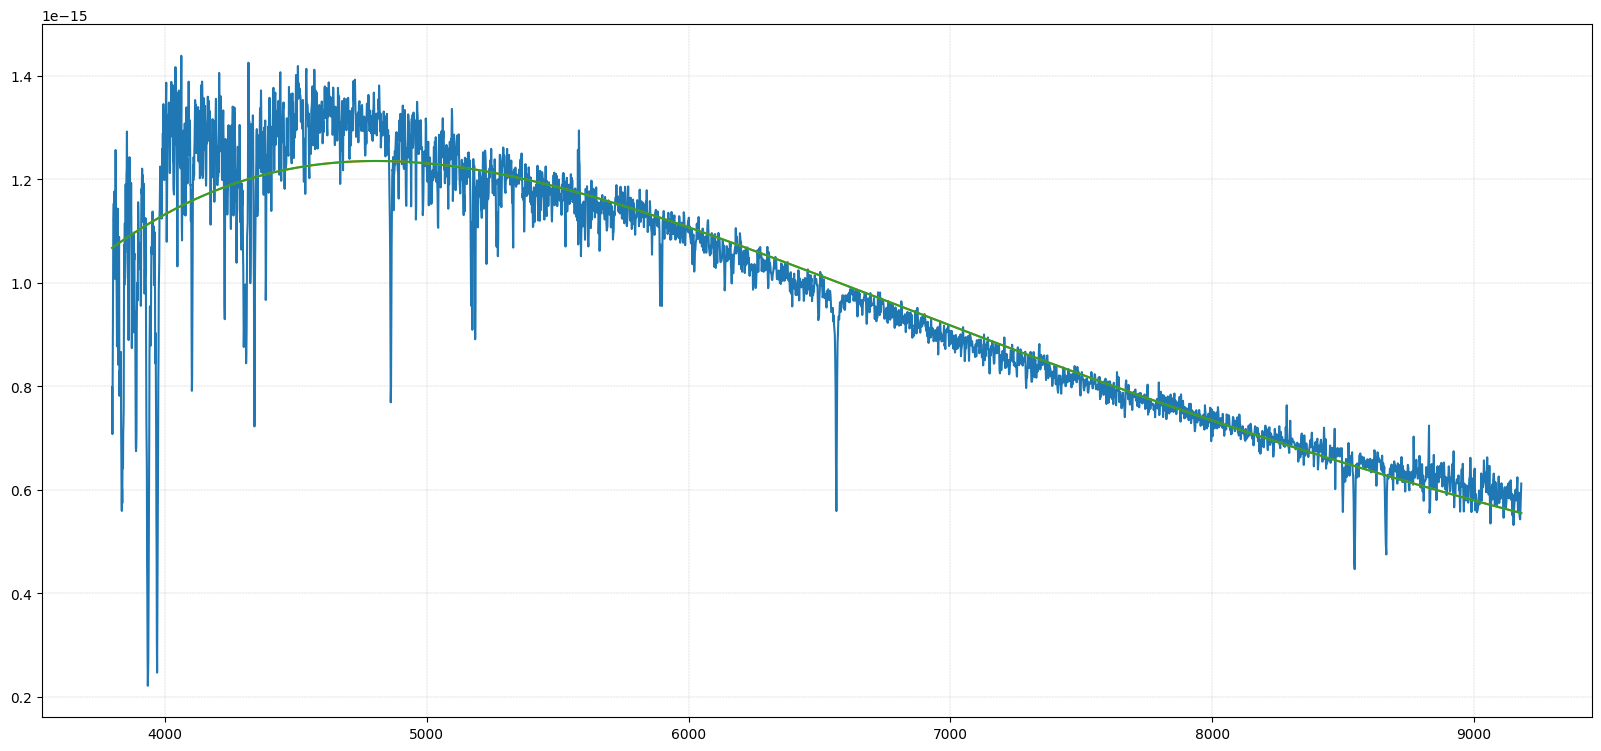

In [7]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength, flux)
ax.plot(wavelength, flux_fitted)
ax.plot(wavelength, bb_flux_fitted)


U: delta extended:0.3808870163127871, delta fitted:0.315075593496676
G: delta extended:0.02959796496020317, delta fitted:0.004959265955616132
R: delta extended:0.051644422685694025, delta fitted:0.07617356369545192
I: delta extended:0.0489193654698461, delta fitted:0.06480940032599136
Z: delta extended:0.3045998484834218, delta fitted:0.04009272928673191


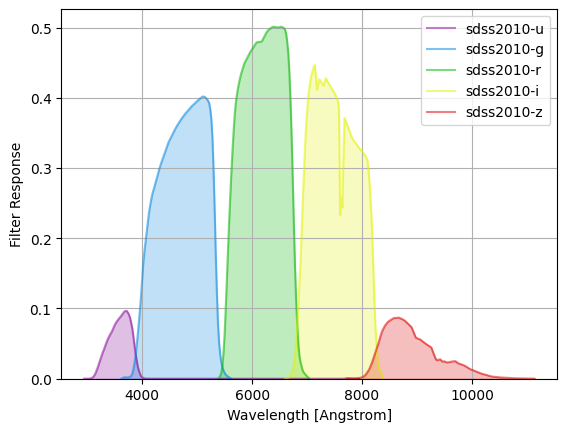

In [8]:
# Try computing apparent magnitudes with speclite filters and compare against SDSS values.
sdss2010 = speclite.filters.load_filters('sdss2010-*')
flux_extended, wavelength_extended = sdss2010.pad_spectrum(flux, wavelength)
flux_fitted_extended = planck_wavelength(wavelength_extended, fitted_temperature, fitted_scale)

ab_magnitudes = sdss2010.get_ab_magnitudes(flux_extended, wavelength_extended)
fitted_ab_magnitudes = sdss2010.get_ab_magnitudes(flux_fitted_extended, wavelength_extended)

apparent_magnitude_u = ab_magnitudes['sdss2010-u'][0]
apparent_magnitude_g = ab_magnitudes['sdss2010-g'][0]
apparent_magnitude_r = ab_magnitudes['sdss2010-r'][0]
apparent_magnitude_i = ab_magnitudes['sdss2010-i'][0]
apparent_magnitude_z = ab_magnitudes['sdss2010-z'][0]

fitted_apparent_magnitude_u = fitted_ab_magnitudes['sdss2010-u'][0]
fitted_apparent_magnitude_g = fitted_ab_magnitudes['sdss2010-g'][0]
fitted_apparent_magnitude_r = fitted_ab_magnitudes['sdss2010-r'][0]
fitted_apparent_magnitude_i = fitted_ab_magnitudes['sdss2010-i'][0]
fitted_apparent_magnitude_z = fitted_ab_magnitudes['sdss2010-z'][0]


print("U: delta extended:{}, delta fitted:{}".format(modelMag_u-apparent_magnitude_u, modelMag_u-fitted_apparent_magnitude_u))
print("G: delta extended:{}, delta fitted:{}".format(modelMag_g-apparent_magnitude_g, modelMag_g-fitted_apparent_magnitude_g))
print("R: delta extended:{}, delta fitted:{}".format(modelMag_r-apparent_magnitude_r, modelMag_r-fitted_apparent_magnitude_r))
print("I: delta extended:{}, delta fitted:{}".format(modelMag_i-apparent_magnitude_i, modelMag_i-fitted_apparent_magnitude_i))
print("Z: delta extended:{}, delta fitted:{}".format(modelMag_z-apparent_magnitude_z, modelMag_z-fitted_apparent_magnitude_z))

speclite.filters.plot_filters(sdss2010)



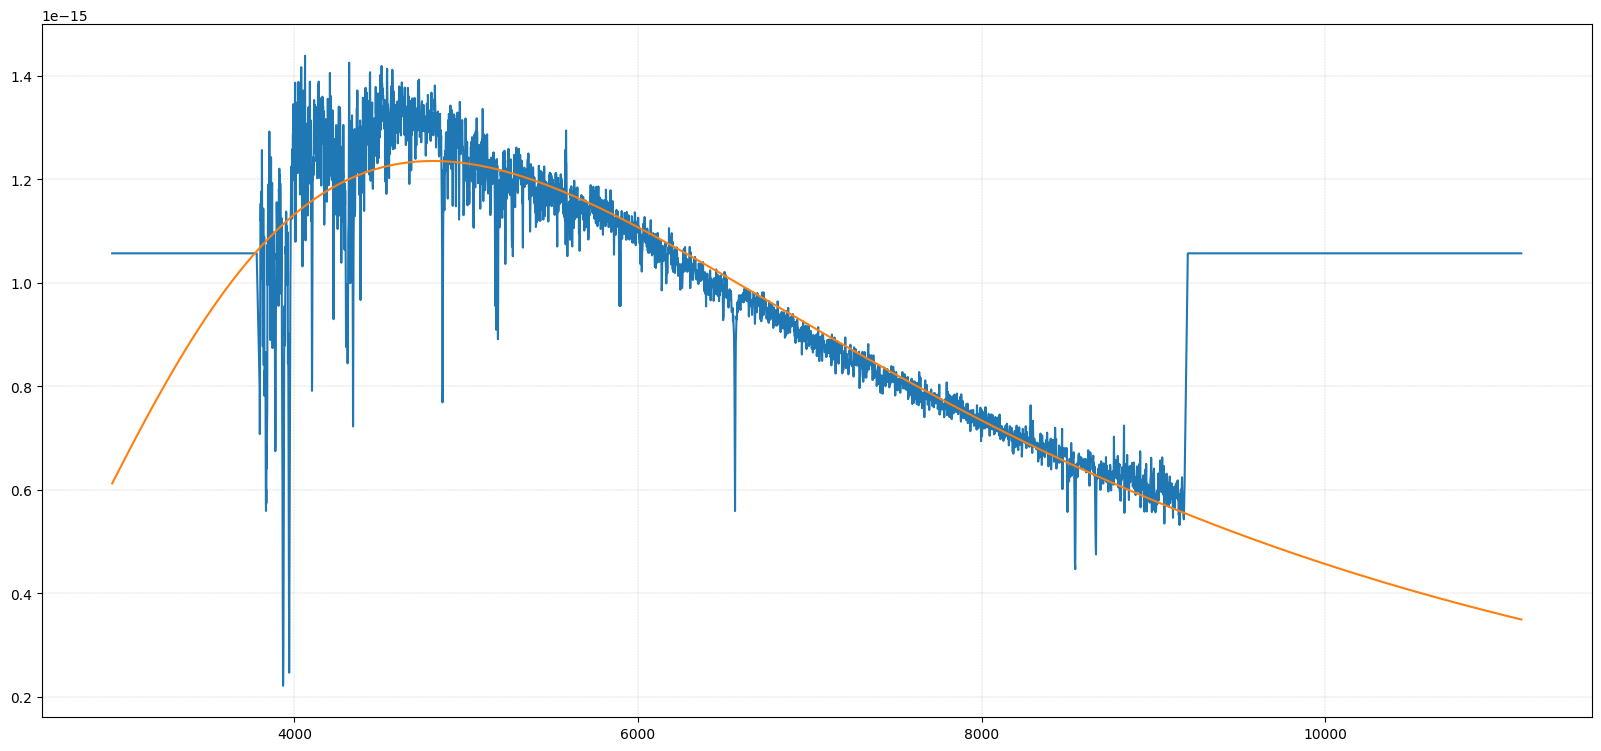

In [9]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength_extended, flux_extended)
ax.plot(wavelength_extended, flux_fitted_extended)